In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [26]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())

In [27]:
df = pd.read_csv('../../data/data/H161.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure','vac_temp']

/tmp/ipykernel_5048/989698433.py:1: DtypeWarning: Columns (1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/data/H161.csv', parse_dates=['utc_time'])


In [28]:
df = df[df['phase'].str.contains ('DRYING|DISCHRG') == True]

In [29]:
df["time"] = df["time"].dt.tz_localize(None)
df['date'] = df['time'].dt.date

In [30]:
df.replace({'??????': None}, inplace=True)
df.replace({'????????': None}, inplace=True)
df.dropna(inplace=True)

In [31]:
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float)
df['phase'] = df.phase.astype('category')

In [32]:
n = 180  # number of points to be checked before and after

# Find local peaks
df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']

In [33]:
df.head(200)

,time,batch,phase,heat_time,weight,head_temp,head_pressure,vac_temp,date,max_temp
28,2020-04-17 11:49:11,22096.0,DRYING,25.4,3956.1,57.5,186.7,31.27,2020-04-17,NaN
29,2020-04-17 11:50:11,22096.0,DRYING,26.4,3954.5,57.5,186.2,31.34,2020-04-17,NaN
30,2020-04-17 11:51:11,22096.0,DRYING,27.4,3952.9,57.5,185.7,31.42,2020-04-17,NaN
31,2020-04-17 11:52:11,22096.0,DRYING,28.4,3951.4,57.5,185.2,31.50,2020-04-17,NaN
32,2020-04-17 11:53:11,22096.0,DRYING,29.4,3949.8,57.5,184.7,31.58,2020-04-17,NaN
...,...,...,...,...,...,...,...,...,...,...
245,2020-04-17 15:26:11,22097.0,DRYING,19.8,3983.8,65.8,384.4,28.24,2020-04-17,NaN
246,2020-04-17 15:27:11,22097.0,DRYING,20.7,3986.7,65.9,391.3,28.16,2020-04-17,NaN
247,2020-04-17 15:28:11,22097.0,DRYING,21.8,3982.9,66.3,328.7,28.11,2020-04-17,NaN
248,2020-04-17 15:29:11,22097.0,DRYING,22.8,3978.2,66.3,295.0,28.12,2020-04-17,NaN


In [34]:
def load_query(path):
    with open(path) as file:
        return file.read()

In [35]:
query = load_query('queries/daily_cycles.sql')
daily_cycles = pysqldf(query)

In [36]:
daily_cycles.sample(4)

,DATE,num_cycles
183,2020-10-28,4
655,2022-02-27,3
420,2021-06-28,4
376,2021-05-15,5


In [37]:
daily_cycles.describe()

,num_cycles
count,694.000000
mean,4.923631
std,3.961385
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,53.000000


In [38]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

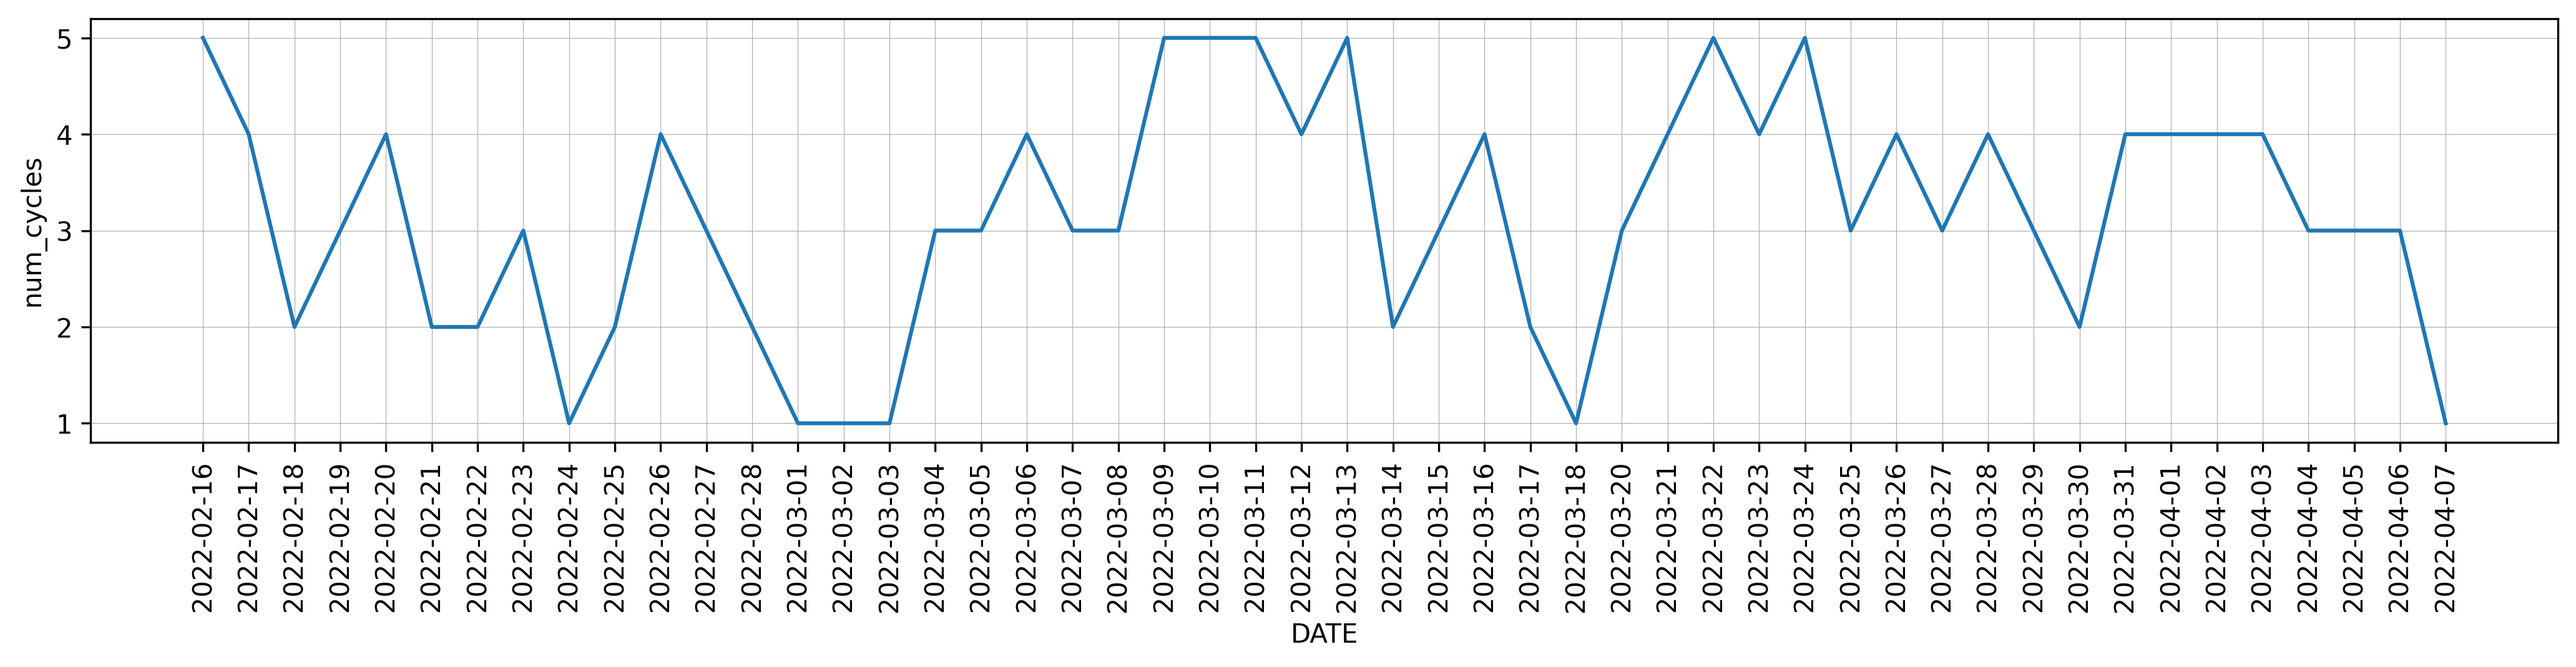

In [39]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_cycles.tail(50), x='DATE', y='num_cycles')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [40]:
query = load_query('queries/weekly_cycles.sql')
weekly_cycles = pysqldf(query)

In [41]:
weekly_cycles.tail()

,week,num_cycles
99,2022-03-06,43
100,2022-03-13,28
101,2022-03-20,44
102,2022-03-27,36
103,2022-04-03,20


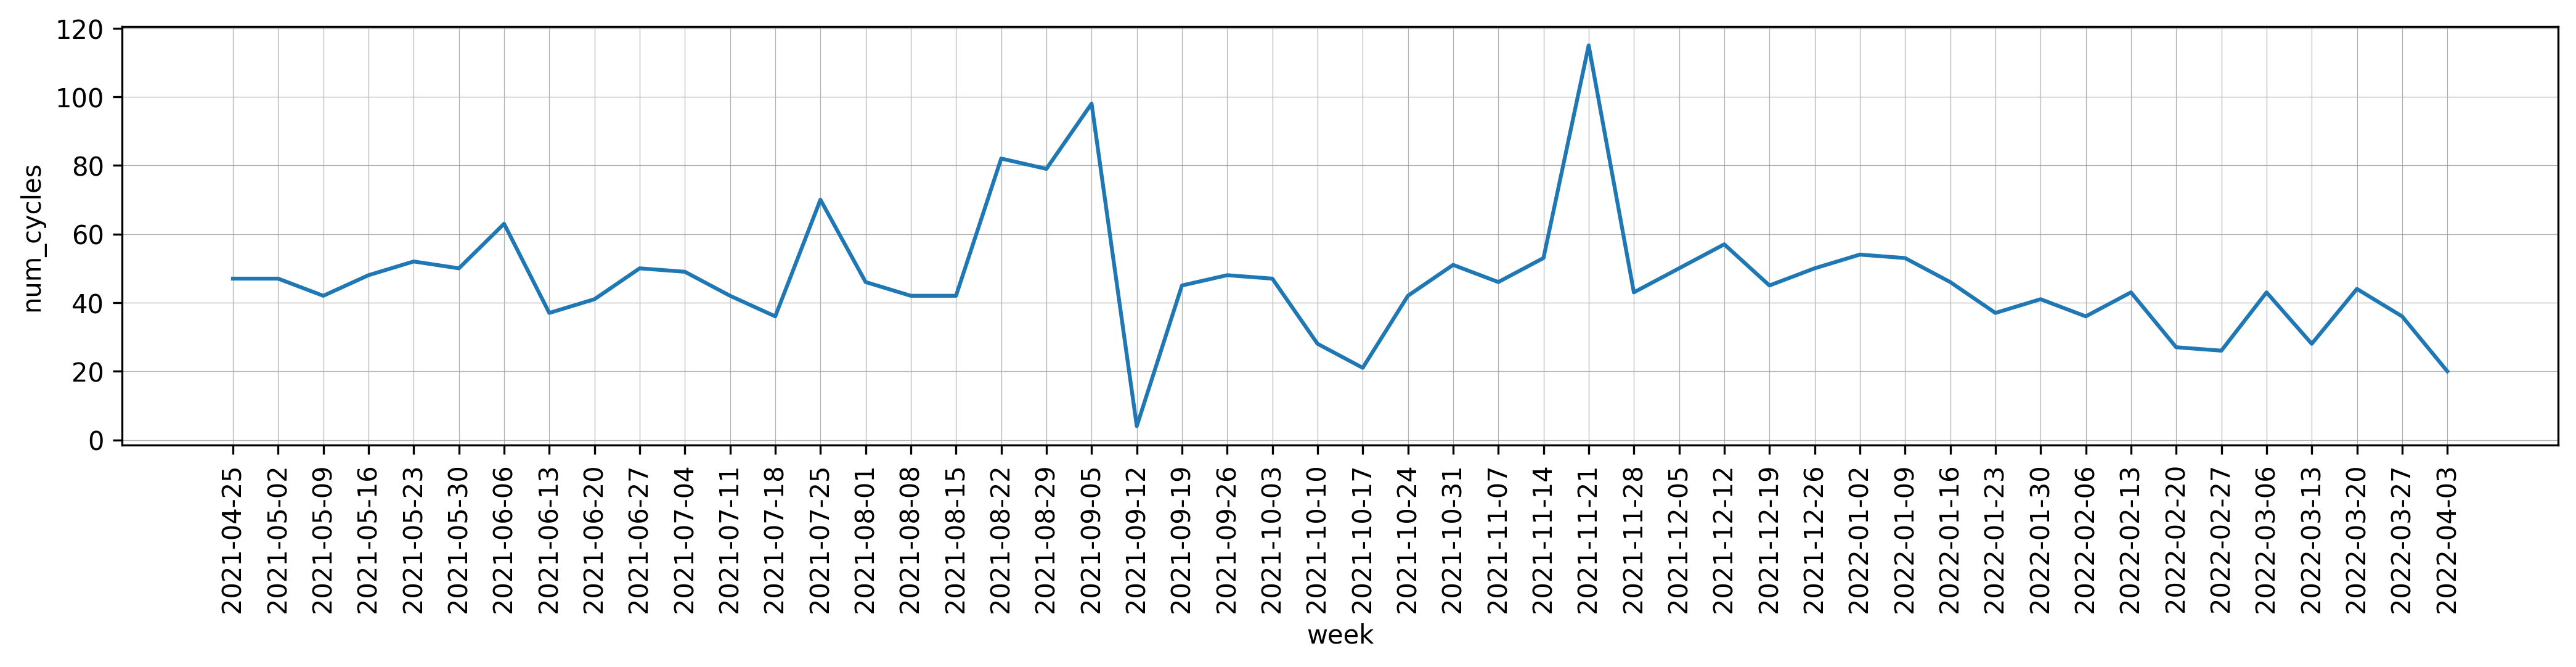

In [42]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_cycles.tail(50), x='week', y='num_cycles')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)